In [1]:
import warnings
from dotenv import load_dotenv

warnings.filterwarnings('ignore')
load_dotenv()

import requests

from typing import List

from haystack import Document, Pipeline, component
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.utils.auth import Secret


### Basic Haystack Component Creation

1. Use @component decorator before component class
2. Create a component class by the name of component you want to make
3. There should be a run method of the class
4. Output Types should be declared categorically suing @components.output_types(var_name=type)

In [2]:
@component
class Greeter:
    @component.output_types(greeting=str)
    def run(self, user_name: str = "Amad"):
        return {"greeting" : f"Hello, {user_name}"}

In [3]:
greeter = Greeter()
greeter.run(user_name="Ali")

{'greeting': 'Hello, Ali'}

### Add the Component to a Pipeline 

In [4]:
template = """ You will be given the beginning of a dialogue. 
Create a short play script using this as the start of the play.
Start of dialogue: {{ dialogue }}
Full script: 
"""

prompt = PromptBuilder(template = template)
llm = OpenAIGenerator(api_key = Secret.from_env_var("GROQ_API_KEY"),
                      api_base_url = "https://api.groq.com/openai/v1",
                      model="llama3-8b-8192",
                      generation_kwargs = {"max_tokens": 512}                      
                      )

dialog_pipeline = Pipeline()
dialog_pipeline.add_component("greeter", greeter)
dialog_pipeline.add_component("prompt", prompt)
dialog_pipeline.add_component("llm", llm)

dialog_pipeline.connect("greeter.greeting", "prompt.dialogue")
dialog_pipeline.connect("prompt", "llm")

🚅 Components
  - greeter: Greeter
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - greeter.greeting -> prompt.dialogue (str)
  - prompt.prompt -> llm.prompt (str)

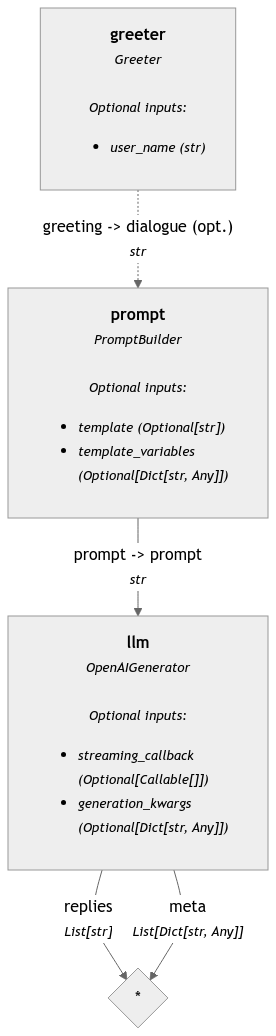

In [5]:
dialog_pipeline.show()

In [6]:
dialog = dialog_pipeline.run(
    {
        "greeter": {"user_name" : "Ali"}
    }
)
print(dialog["llm"]["replies"][0])

The completion for index 0 has been truncated before reaching a natural stopping point. Increase the max_tokens parameter to allow for longer completions.


Here is a short play script starting with the dialogue "Hello, Ali":

**Title:** "The Unexpected Reunion"

**Characters:**

* LEILA, a successful businesswoman in her late 30s
* ALI, an old friend from childhood

**Setting:** A trendy coffee shop in the financial district of a large city

**Act 1:**

(The scene opens with LEILA sitting at a small table, typing away on her laptop. The door swings open and ALI walks in, looking around awkwardly. He spots LEILA and approaches her table.)

ALI: Hello, Ali.

LEILA: (looking up, surprised) Oh my god, Ali! It's been ages! What are you doing here?

ALI: (sitting down across from her) Just grabbing a coffee before a meeting. How about you? What brings you to this neck of the woods?

LEILA: (smiling wryly) I'm in negotiations with a potential investor for my company. Trying to seal the deal.

ALI: (impressed) That sounds exciting. I remember when you were just a little girl with a lemonade stand. Who would have thought you'd be a successful busi

In [7]:
dialog = dialog_pipeline.run({})
print(dialog["llm"]["replies"][0])

Here is a short play script using the given dialogue as the start:

**"The Unexpected Visit"**

**Characters:**

* Amar, a young professional in his late 20s
* Amad, Amar's estranged father, a middle-aged man with a stern expression
* Aneeka, Amar's childhood friend and confidant, a free-spirited artist in her mid-twenties

**Setting:** Amar's modern apartment in the city. A small table with two chairs is set against one wall, while a minimalist couch and coffee table occupy the center of the room. Aneeka sits on the couch, adjusting her sketchbook.

**Act 1, Scene 1**

(Amar answers the door, surprised to see his father standing there. He takes a deep breath, composing himself before stepping aside to let him in.)

AMAR: Hello, Amad.

AMAD: (coldly) Amar. I've been looking for you.

ANEeka: (nodding in recognition) Hi, Amad. It's been a while.

AMAD: (ignoring Aneeka) We need to talk, Amar.

AMAR: (hesitant) What is it?

AMAD: (his expression darkening) Your mother wants to see you. S

### News Sumamrizer

In [16]:
trending_list = requests.get(
        url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
    )
post = requests.get(
    url=f"https://hacker-news.firebaseio.com/v0/item/{trending_list.json()[0]}.json?print=pretty"
)

print(post.json())

{'by': 'goles', 'descendants': 1, 'id': 41658766, 'kids': [41659592], 'score': 66, 'time': 1727360676, 'title': 'NKRYPT Sculpture', 'type': 'story', 'url': 'https://www.meme.net.au/nkrypt/'}


In [22]:
@component
class HackerNewsFetcher:
    def __init__(self) -> None:
        fetcher = LinkContentFetcher()
        converter = HTMLToDocument()
        html_to_doc_converter = Pipeline()
        html_to_doc_converter.add_component("fetcher", fetcher)
        html_to_doc_converter.add_component("converter", converter)
        
        html_to_doc_converter.connect("fetcher", "converter")
        
        self.conversion_pipeline = html_to_doc_converter
        
    @component.output_types(articles = List[Document])
        
    def run(self, top_k: int):
        articles = []
        trending_list = requests.get(
        url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
        )
        for id in trending_list.json()[0:top_k]:
            post = requests.get(
                    url=f"https://hacker-news.firebaseio.com/v0/item/{id}.json?print=pretty"
                )
            # print(post.json()['url'])
            if "url" in post.json():
                try:
                    article = self.conversion_pipeline.run(
                        {"fetcher": {"urls": [post.json()["url"]]}}
                        )
                    articles.append(article["converter"]["documents"][0])
                except:
                    print(f"Can't download {post}, skipped")
            elif "text" in post.json():
                try:
                        articles.append(Document(content=post.json()["text"], meta= {"title": post.json()["title"]}))
                except:
                        print(f"Can't download {post}, skipped")
        return {"articles": articles}

In [23]:
fetcher = HackerNewsFetcher()
results = fetcher.run(top_k=5)

print(results['articles'])

[Document(id=a8642bce281673c12394c59f576a855d0d6fba38200a2fd7be9899efba36ad5f, content: 'NKRYPT is a cryptography related installation outside the Questacon science exploration centre in Ca...', meta: {'content_type': 'text/html', 'url': 'https://www.meme.net.au/nkrypt/'}), Document(id=29c9412c74b45945be6f819f30974589b77ac599e0c0c6b839c501c4451b3193, content: 'XKCD 1425 (Tasks) turns ten years old today (via) One of the all-time great XKCDs. It's amazing that...', meta: {'content_type': 'text/html', 'url': 'https://simonwillison.net/2024/Sep/24/xkcd-1425-turns-ten-years-old-today/'}), Document(id=28efb7ed71f6d9e94e009e74a6402703c1585e457a2855686a8084c6af90ff3a, content: 'Italian Music through the Lens of Complex Networks
Last year I was talking with a non-Italian, tryin...', meta: {'content_type': 'text/html', 'url': 'https://www.michelecoscia.com/?p=2372'}), Document(id=e7f1e276a0393e4ba6f84b0b96db9945e7bf83b03504940908f6beaeb4996523, content: 'By Paweł Płatek
In the race to secure cl

In [24]:
prompt_template = """  
You will be provided a few of the top posts in HackerNews.  
For each post, provide a brief summary if possible.
  
Posts:  
{% for article in articles %}
  Post:\n
  {{ article.content}}
{% endfor %}  
"""

In [25]:
prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackerNewsFetcher()
llm = OpenAIGenerator(api_key = Secret.from_env_var("GROQ_API_KEY"),
                      api_base_url = "https://api.groq.com/openai/v1",
                      model="llama3-8b-8192",
                      generation_kwargs = {"max_tokens": 512}
)

news_summarizer = Pipeline()
news_summarizer.add_component("fetcher", fetcher)
news_summarizer.add_component("prompt_builder", prompt_builder)
news_summarizer.add_component("llm", llm)

news_summarizer.connect("fetcher.articles", "prompt_builder.articles")
news_summarizer.connect("prompt_builder", "llm")



🚅 Components
  - fetcher: HackerNewsFetcher
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - fetcher.articles -> prompt_builder.articles (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

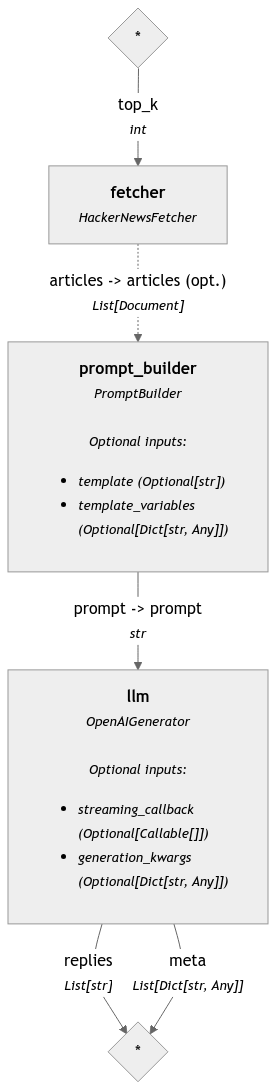

In [26]:
news_summarizer.show()

In [28]:
summaries = news_summarizer.run(
    {"fetcher":{"top_k":3}}
)

print(summaries['llm']['replies'][0])

Here are the summaries for each post:

1. **NKRYPT**: The post describes a series of cryptographic puzzles and challenges, including a scytale wrapped around a hexagonal baton, a Braille cipher, and a rotor cipher. Many of the puzzles have not been solved, and the post invites readers to contribute their own solutions.

2. **XKCD 1425 (Tasks)**: This post celebrates the 10th anniversary of XKCD 1425, a popular comic strip that pokes fun at the challenge of distinguishing between easy and hard tasks in software development. The post argues that the rise of artificial intelligence (AI) has made it even more difficult to understand the difference between easy and hard tasks.

3. **Italian Music through the Lens of Complex Networks**: This post describes a study that maps Italian music as a complex network of collaborations between artists and bands. The study uses data from Wikipedia and Discogs to create a bipartite network, which is then analyzed using various network metrics. The resul